### Importing the modules

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Dataset inclusion

In [39]:
DATASET_DIR = "Dataset/TTD"

TRAIN_DIR = DATASET_DIR + "/train"
VALID_DIR = DATASET_DIR + "/valid"
TEST_DIR = "Dataset/test"


print(TRAIN_DIR)
print(VALID_DIR)

Dataset/TTD/train
Dataset/TTD/valid


### 🖼️ Image Preprocessing Configuration
* **Input Resolution:** 224x224 pixels
* **Batch Size:** 32 images per iteration
* **Augmentation Strategy:** Horizontal flipping enabled for training to improve generalization.
* **Normalization:** Applied using standard ImageNet parameters ($\mu=[0.485, 0.456, 0.406]$, $\sigma=[0.229, 0.224, 0.225]$).

In [40]:
IMAGE_SIZE =224
BATCH_SIZE = 32
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )#standard numbers based on large google image dataset
])

valid_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )#standard numbers based on large google image dataset
])

### Loading DataSet

In [41]:
train_dataset = datasets.ImageFolder(
    root=TRAIN_DIR,
    transform=train_transform
)

valid_dataset = datasets.ImageFolder(
    root=VALID_DIR,
    transform=train_transform
)

In [42]:
#Checking if the labels are beimg loaded

print("No. of classes:", len(train_dataset.classes))
print(train_dataset.classes)

No. of classes: 38
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 

### Creating dataloaders

In [43]:
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
valid_loader = DataLoader(valid_dataset,batch_size=BATCH_SIZE,shuffle=False)

In [44]:
images, labels = next(iter(train_loader))
print(images.shape)   # it shows how will be the data will be there like
#32 is batch size that is input, 3 is the Channels that is RGB colors, 224x224 is size of our image
print(labels.shape)   # it will the batch size


torch.Size([32, 3, 224, 224])
torch.Size([32])


Enabling the cuda and our gpu

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device is:", device)

Device is: cuda


#### Architecture began

core architecture

In [46]:
class CropDiseaseCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        #Features Taking out
        self.features = nn.Sequential(
            #Layer 1 or Block 1
            nn.Conv2d(3,32,kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), # 224 ->112

            #Layer 2 or Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), #112 to 56

            #Layer 3 or Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), # 56 to 28
        )

        # Classifier and Flattening the Pooled layers
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*28*28, 512),# 128 is filters, 28x28 is size and 512 is output
            nn.ReLU(),
            nn.Dropout(0.5),#a regularization technique that is used to prevent our model from overfitting
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

Model Intialization

In [47]:
num_classes = len(train_dataset.classes)

model = CropDiseaseCNN(num_classes).to(device)

print(model)

CropDiseaseCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=38, bias=True)
  )
)


Forward pass check

In [48]:
images, labels = next(iter(train_loader))
images = images.to(device)

outputs = model(images)
print(outputs.shape)


torch.Size([32, 38])


### Loss function and optimizer

In [49]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr =0.0003)

Training Starts

In [50]:
Epochs = 5
train_acc_history =[]
val_acc_history = []

for epoch in range(Epochs):
    #Training Phase will take time 
    model.train()
    running_loss = 0.0
    correct = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss +=loss.item()
        correct+=(outputs.argmax(1) == labels).sum().item()
    train_acc = correct/len(train_dataset)
    train_acc_history.append(train_acc)

    #Validation Phase 
    model.eval()
    val_correct =0

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_correct +=(outputs.argmax(1) == labels).sum().item()
    
    val_acc = val_correct / len(valid_dataset)
    val_acc_history.append(val_acc)

    print(f"Epoch [{epoch+1}/{Epochs}] | "
          f"Train Acc:{train_acc:.4f} |"
          f"Val Acc: {val_acc:.4f}")

Epoch [1/5] | Train Acc:0.6494 |Val Acc: 0.8699
Epoch [2/5] | Train Acc:0.8456 |Val Acc: 0.9220
Epoch [3/5] | Train Acc:0.8888 |Val Acc: 0.9383
Epoch [4/5] | Train Acc:0.9103 |Val Acc: 0.9494
Epoch [5/5] | Train Acc:0.9261 |Val Acc: 0.9550


In [25]:
print(train_dataset.classes == valid_dataset.classes)


True


#### Saving the model

In [53]:
torch.save({
    "model_state": model.state_dict(),
    "class_names":train_dataset.classes
}, "crop_disease_model.pth")

print("model saved successfully")

model saved successfully


Plot Accuracy

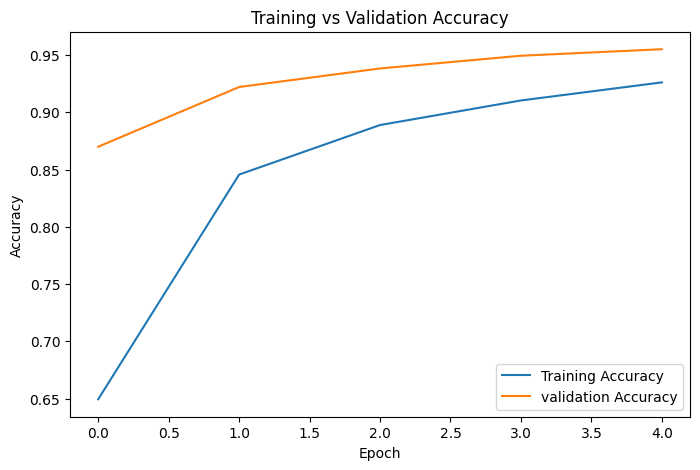

In [54]:
plt.figure(figsize=(8,5))
plt.plot(train_acc_history, label="Training Accuracy")
plt.plot(val_acc_history, label="validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()